## Goal: 

Inspect what happens to the results if we discard the first $n$ votes per user (try a few values for $n$)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')

from sf_lib.helpers import (
    get_cols,
    get_column_names
)

%matplotlib inline

In [2]:
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")

In [3]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook

# contains results if we keep all votes
df_votes = pd.read_json('df_votes.json')

# contains results if we discard the first 5 votes of each user
df_votes_e5 = pd.read_json('df_votes_exclude_5.json')
df_votes_e10 = pd.read_json('df_votes_exclude_10.json')
df_votes_e25 = pd.read_json('df_votes_exclude_25.json')
df_votes_e50 = pd.read_json('df_votes_exclude_50.json')
df_votes_e250 = pd.read_json('df_votes_exclude_250.json')

df = pd.read_json('df_stacked.json')

__To start, we'll compare the total dataset (excluding none of the votes) to the subset where we discard each user's first 5 votes.__

We can compare other subsets of data by changing the `dfs` and `ns` below:

In [4]:
dfs = [df_votes, df_votes_e50]
ns = [0,50]
labels = ['n_ex = {}'.format(n) for n in ns]

colors = [
    'xkcd:lightish blue',
    'xkcd:orange'
]

In [5]:
print('Total object count:')
for i, df in enumerate(dfs):
    print('\t{}: {}'.format(labels[i], df.shape[0]))

Total object count:
	n_ex = 0: 6362
	n_ex = 50: 6362


### Do objects still have enough votes to be statistically significant?

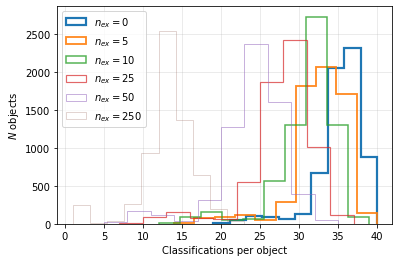

In [6]:
fig, fr = plt.subplots(figsize=(6,4))

hist_kw = dict(
    histtype='step',
    facecolor='none',
    lw=1.5,
    alpha=0.7
)

_ns = [0, 5, 10, 25, 50, 250]
alphas = np.linspace(1, 0.5, 6)
lws = np.linspace(2.2, 0.5, 6)
for i, df in enumerate([df_votes, df_votes_e5, df_votes_e10, df_votes_e25, df_votes_e50, df_votes_e250][::1]):
    hist_kw['alpha'] = alphas[i]
    hist_kw['label'] = '$n_{ex}=$' + r'${}$'.format(_ns[i])
    hist_kw['lw'] = lws[i]
    fr.hist(df['vote_count'], **hist_kw)
    
fr.update(dict(
    xlabel='Classifications per object',
    ylabel='$N$ objects'
))

fr.grid(alpha=0.3)
fr.legend(loc='upper left')

plt.savefig('./plots_final/exclude/count'.format(ns[0], ns[1]), dpi=200, bbox_inches='tight')
plt.show()

### Does the T0 distribution change appreciably?

In [7]:
t0cols = get_column_names('T0', df_votes); print(t0cols)

['T0', 'T0 % galaxy', 'T0 % group of objects (cluster)', 'T0 % something else/empty center']


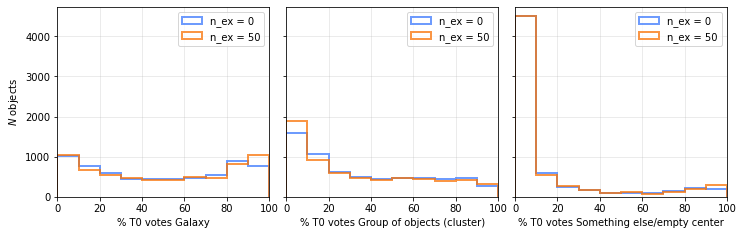

In [16]:
fig, fr = plt.subplots(1,3, figsize=(12,3.5), sharey=True, gridspec_kw=dict(wspace=0.08))

for i, df in enumerate(dfs):
    hist_kw['alpha'] = 0.75
    hist_kw['lw'] = 2
    for frame_index in range(3):
        hist_kw['edgecolor'] = colors[i]
        hist_kw['label'] = labels[i]
        fr[frame_index].hist(df[t0cols[1:][frame_index]], **hist_kw, bins=10)
        
for i in range(3):
    fr[i].grid(alpha=0.3)
    fr[i].update(dict(xlim=[0,100], xlabel='% T0 votes {}'.format(t0cols[1:][i][5:].capitalize())))
    fr[i].legend(loc='upper right')
    
fr[0].update(dict(ylabel='$N$ objects'))

plt.savefig('./plots_final/exclude/T0 - {} vs {}'.format(ns[0], ns[1]), dpi=200, bbox_inches='tight')
plt.show()

### Are there objects that get a majority _Galaxy_ in one case, but not in the other?

In [9]:
q = "`T0 % galaxy` >= 75"

consensus_flip = list(set(dfs[0].query(q)['name']).symmetric_difference(set(dfs[1].query(q)['name'])))

In [10]:
flip_gal_votes = [
    (
        dfs[0].query('name == @name').iloc[0]['T0 % galaxy'],
        dfs[1].query('name == @name').iloc[0]['T0 % galaxy']
    ) for name in consensus_flip
]

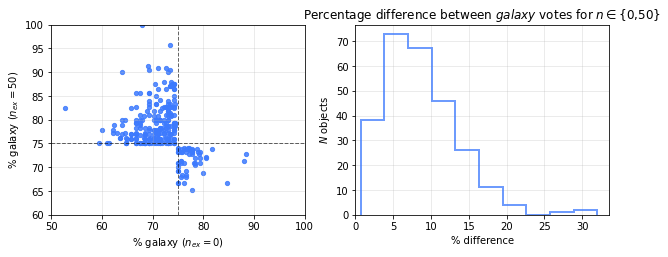

In [34]:
x, y = np.array(flip_gal_votes).T

kw = dict(s=18, alpha=0.85, c='xkcd:lightish blue')
line_kw = dict(alpha=0.6, color='black', ls='--', lw=1)

fig, fr = plt.subplots(1,2, figsize=(10,3.5))
fr[0].scatter(x, y, **kw)
fr[0].update(dict(
    xlabel='% galaxy ($n_{ex} = 0$)',
    ylabel='% galaxy ($n_{ex} = 50$)',  # change this manually if we want to compare other subsets
    xlim=[50,100],
    ylim=[60,100]
))

fr[0].grid(alpha=0.3)

fr[0].axhline(75, **line_kw)
fr[0].axvline(75, **line_kw)

hist_kw['edgecolor'] = 'xkcd:lightish blue'
fr[1].hist(np.abs(x-y), **hist_kw)

fr[1].update(dict(
    xlabel=('% difference'),
    ylabel='$N$ objects',
    title=r"Percentage difference between $galaxy$ votes for $n \in$" + '{' + str(ns[0]) + ',' + str(ns[1]) + '}',
    xlim=0
))
fr[1].grid(alpha=0.3)

plt.savefig('./plots_final/exclude/T0 galaxy flip - {} vs {}'.format(ns[0], ns[1]), dpi=200, bbox_inches='tight')
plt.show()

We observe that there are some objects that get at least 50% _Galaxy_ votes in one case, but not in the other case. However, the resulting difference is always within 10%.

### Does the T1 distribution change appreciably?

In [ ]:
t1cols = get_column_names('T1', df_votes); print(t1cols)

In [ ]:
fig, fr = plt.subplots(1, 2, figsize=(10,3.5), sharey=True, gridspec_kw=dict(wspace=0.08))

for i, df in enumerate(dfs):
    for frame_index in range(2):
        hist_kw['edgecolor'] = colors[i]
        hist_kw['label'] = labels[i]
        fr[frame_index].hist(df[t1cols[1:][frame_index]], **hist_kw, bins=10)
        
for i in range(2):
    fr[i].grid(alpha=0.3)
    fr[i].update(dict(xlim=[0,100], xlabel='% T1 votes {}'.format(t1cols[1:][i][5:].capitalize())))
    fr[i].legend(loc='upper center')
    
fr[0].update(dict(ylabel='$N$ objects'))

plt.savefig('./plots_final/exclude/T1 - {} vs {}'.format(ns[0], ns[1]), dpi=200, bbox_inches='tight')
plt.show()

### Does the agreement with likely ground truth (LGT) change?

In [ ]:
q = "`T0 % galaxy` >= 75 & `T1 % fluffy` >= 75"

fluf_consensus_flip = set(dfs[0].query(q)['name']).symmetric_difference(dfs[1].query(q)['name'])

In [ ]:
flip_fluf_votes = [
    [(
        dfs[0].query('name == @name').iloc[0]['T1 % fluffy'],
        dfs[1].query('name == @name').iloc[0]['T1 % fluffy']
    ), 
    (
        dfs[0].query('name == @name').iloc[0]['T0 % galaxy'],
        dfs[1].query('name == @name').iloc[0]['T0 % galaxy']
    )] for name in fluf_consensus_flip
]

In [ ]:
x, y = np.array(flip_fluf_votes).T

kw = dict(s=12, alpha=0.85, c='xkcd:lightish blue')

fig, fr = plt.subplots(1,3, figsize=(12,3.5), gridspec_kw=dict(wspace=0.3))

fr[1].scatter(x[0], y[0], **kw)
fr[0].scatter(x[1], y[1], **kw)

fr[1].update(dict(
    xlabel='% $Fluffy$ ($n_{ex} = 0$)',
    ylabel='% $Fluffy$ ($n_{ex} = 50$)',
    ylim=[35,102],
#     ylim=[65,102],
#     xlim=[60,102]  # manually tweak for visual clarity if we change subsets
    xlim=[35,102],
))

fr[0].update(dict(
    xlabel='% $Galaxy$ ($n_{ex} = 0$)',
    ylabel='% $Galaxy$ ($n_{ex} = 50$)',
    ylim=[35,102],
#     ylim=[60,102],
#     xlim=[60,102]  # manually tweak for visual clarity if we change subsets
    xlim=[35,102],
))

line_kw = dict(alpha=0.6, color='black', ls='--', lw=1)

for i in range(2):
    fr[i].grid(alpha=0.3)
    fr[i].axhline(75, **line_kw)
    fr[i].axvline(75, **line_kw)

hist_kw['edgecolor'] = 'xkcd:lightish blue'
hist_kw['alpha'] = 0.85
hist_kw['lw'] = 1.5
hist_kw['label'] = 'T0 Galaxy'
fr[2].hist(np.abs(x[0]-y[0]), **hist_kw)

hist_kw['edgecolor'] = 'xkcd:orange'
hist_kw['label'] = 'T1 Fluffy'
fr[2].hist(np.abs(x[1]-y[1]), **hist_kw)

fr[2].update(dict(
    xlabel='% difference between $n={}$ and $n={}$ exclusion'.format(ns[0], ns[1]),
    ylabel='$N$ objects',
    xlim=0
))

fr[2].grid(alpha=0.3)
fr[2].legend()
   
plt.savefig('./plots_final/exclude/gal-fluffy flip - {} vs {}'.format(ns[0], ns[1]), dpi=200, bbox_inches='tight')

plt.show()

Above, we've plotted all objects that don't satisfy (`T0 % galaxy >= 75 & T1 % fluffy >=75`) in either of the subsets, but do satisfy those equalities in the other subset.

Here, we also see the difference never exceeds 10% for either the T0 galaxy percentage or the T1 fluffy percentage.

__So far, we've been comparing the n=0 exclusion set to the n=5 exclusion set. We could easily modify the above code to compare any exclusion set, though.__

#### Agreement numbers:

In [ ]:
df_votes_power = pd.read_json('df_votes_power_users.json')

In [ ]:
dfs = [df_votes, df_votes_e5, df_votes_e25, df_votes_e50, df_votes_e250, df_votes_power]

q_fluf_50 = '\
            `T0 % galaxy` >= 50 &\
            `T1 % fluffy` >= 75 \
        '

q_fluf_75 = '\
            `T0 % galaxy` >= 75 &\
            `T1 % fluffy` >= 75 \
        '

q_50 = '\
            name.isin(@catalogue_targets) &\
            `T0 % galaxy` >= 50 &\
            `T1 % fluffy` >= 75 \
        '

q_75 = '\
            name.isin(@catalogue_targets) &\
            `T0 % galaxy` >= 75 &\
            `T1 % fluffy` >= 75 \
        '

print('LGT objects correctly classified (gal threshold 75%)')
for i in range(len(dfs)):
    print(
        dfs[i].query(q_75).shape[0], 
        dfs[i].query(q_fluf_75).shape[0],
        round(100*dfs[i].query(q_75).shape[0]/dfs[i].query(q_fluf_75).shape[0], 1)
    )
    
print('\nLGT objects correctly classified (gal threshold 50%)')
for i in range(len(dfs)):
    print(
        dfs[i].query(q_50).shape[0],
        dfs[i].query(q_fluf_50).shape[0],
        round(100*dfs[i].query(q_50).shape[0]/dfs[i].query(q_fluf_50).shape[0], 1)
    )

So, excluding an increasing number of classifications per user results in a correct classification for more and more of the LGT objects. Lowering the threshold for _galaxy_ classifications also increases the number of objects we retrieve, however this might be due to selection effects (if a larger number of users thinks an object isn't a galaxy, it's presumably too faint to notice for them, and thus the percentage of _fluffy_ votes compared to _bright_ votes will naturally also generally be higher).

- Galaxy threshold 75%:

| _n_ first votes excluded | LGT objects correctly classified |
|:-:|:-:|
| 0 | 30 |
| 5 | 33 |
| 25 | 35 |
| 50 | 38 |
| 250 | 48 |

- Galaxy threshold 50%:

| _n_ first votes excluded | LGT objects correctly classified |
|:-:|:-:|
| 0 | 73 |
| 5 | 74 |
| 25 | 74 |
| 50 | 76 |
| 250 | 48 |

#### Are the LGT galaxies that are identified by users as fluffy galaxies the same ones across various exclusion subsets?

In [ ]:
len(set(dfs[0].query(q_75)['name']) & set(dfs[-1].query(q_75)['name'])),\
len(set(dfs[0].query(q_75)['name'])),\
len(set(dfs[-1].query(q_75)['name']))

Note: in the following text blocks I'll refer to e.g. $n=0$. By this I mean the result we obtain if we exclude $n=0$ classifications per user.

From above: Comparing the complete set ($n=0$) to $n=5$, we see that all 30 LGT objects in $n=0$ are also found in $n=5$, but the $n=5$ subset reveals an additional 3 objects from the LGT catalogue.

In [ ]:
len(set(dfs[0].query(q_75)['name']) & set(dfs[-1].query(q_75)['name'])),\
len(set(dfs[0].query(q_75)['name'])),\
len(set(dfs[-1].query(q_75)['name']))

From above: comparing $n=0$ to $n=50$, we see that of the 30 LGT objects found in $n=0$, only 29 are found in $n=50$, however the $n=50$ subset finds 8 objects not found by the $n=0$ subset.

We can expand this classification to higher and higher $n$, however we've seen above (in the first plot in this Notebook) that we drastically reduce the number of votes remaining per object if we do this, and at some point we'll start ending up with objects receiving 0 votes, so $n=50$, which leaves at least 5 votes for all objects, and for which the mean vote count per object is over 20, is sort of a soft limit in our view.

## Considering only power users

In [ ]:
df_votes_power = pd.read_json('df_votes_power_users.json')

In [ ]:
fig, fr = plt.subplots(figsize=(6,5))

hist_kw['edgecolor'] = 'xkcd:lightish blue'
fr.hist(df_votes_power['vote_count'], **hist_kw)
fr.grid(alpha=0.3)
fr.update(dict(
    xlabel='$N$ classifications per object',
    ylabel="$N$ objects"
))
plt.show()